# Machine Learning - Project

In [1]:
%pip install category-encoders
%pip install imbalanced-learn
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install seaborn

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -

# Columns Definitions

Here is the meaning of every columns explain in `Xente_Variable_Definitions.csv`.

 * **TransactionId**: Unique transaction identifier on platform
 * **BatchId**: Unique number assigned to a batch of transactions for processing
 * **AccountId**: Unique number identifying the customer on platform
 * **SubscriptionId**: Unique number identifying the customer subscription
 * **CustomerId**: Unique identifier attached to Account
 * **CurrencyCode**: Country currency
 * **CountryCode**: Numerical geographical code of country
 * **ProviderId**: Source provider of Item bought.
 * **ProductId**: Item name being bought.
 * **ProductCategory**: ProductIds are organized into these broader product categories.
 * **ChannelId**: Identifies if customer used web,Android, IOS, pay later or checkout.
 * **Amount**: Value of the transaction. Positive for debits from customer account and negative for credit into customer account
 * **Value**: Absolute value of the amount
 * **TransactionStartTime**: Transaction start time
 * **PricingStrategy**: Category of Xente's pricing structure for merchants
 * **FraudResult**: Fraud status of transaction 1 -yes or 0-No


# Load training data

The first thing we do is to load the training data from `training.csv`.

In [2]:
training_data_path = './data/training.csv'

# Read data from file
training_data = pd.read_csv(training_data_path)

# Set the 'TransactionId' as index
training_data.set_index('TransactionId', inplace=True)

training_data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# Data analysis

Now that we have our data loaded, we will analyse the differents data in order the get the best possible model.

# Mutual Information

First thing first, we will look at the relationship between every columns and the target value.

In [3]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [5]:
# Define the datasets
X = training_data.copy()
y = X.pop('FraudResult')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Get the discrete features by checking that it is a int
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores


BatchId                 0.118200
TransactionStartTime    0.031543
Amount                  0.016078
AccountId               0.009895
Value                   0.009652
SubscriptionId          0.008456
CustomerId              0.007474
ProductId               0.002219
ProviderId              0.001812
PricingStrategy         0.001323
CurrencyCode            0.000000
CountryCode             0.000000
ProductCategory         0.000000
ChannelId               0.000000
Name: MI Scores, dtype: float64

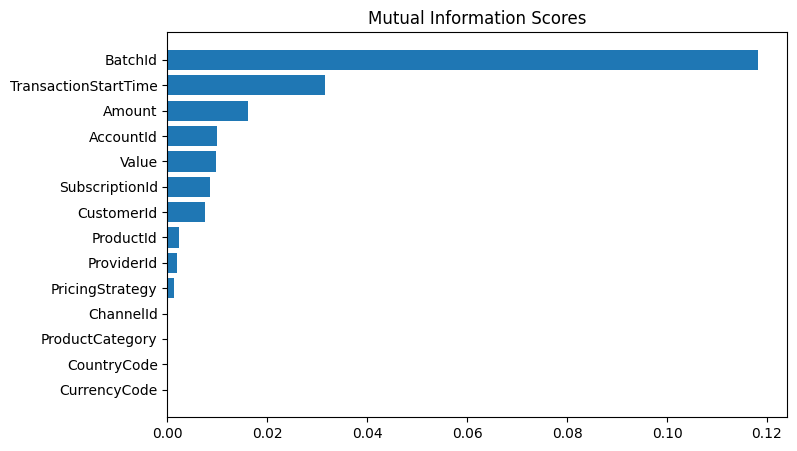

In [6]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we can see in the plot, the `BatchId` is the most dominant columns. But we cannot take this one into account as it is a biased value due to the fact the the `BatchId`is only an identification for the transaction.

Same for `CustomerId`, `AccountId` and `SubscriptionId`, because they refers to customers. We do not want to predict a fraud based on the customers habits.

Based on what have been said before, here is the new Mutual Information removing the following columns: `BatchId`, `CustomerId`, `AccountId` and `SubscriptionId`.

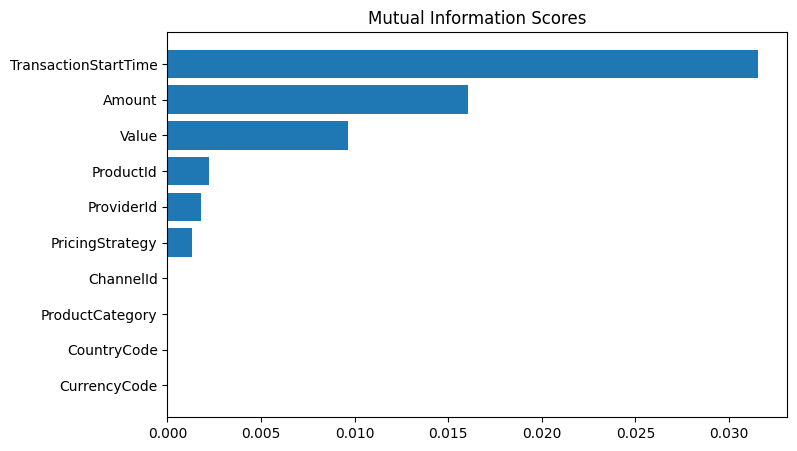

In [7]:
# Define columns to remove
cols_to_remove = ['BatchId', 'CustomerId', 'AccountId', 'SubscriptionId']

# Remove useless columns
mi_scores_copy = mi_scores.drop(cols_to_remove)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores_copy)

## Transaction country

First, we will attack with the columns `CurrencyCode` and `CountryCode`. Actually, they point to the same thing: from which country the transaction has been done. Thus, we can say that having both columns is redundant to estimate our model prediction.

We will first look at the occurence of every country and then check its relationship with the target value.

In [8]:
# Load CurrencyCode and CountryCode
X_currency_code = training_data['CurrencyCode']
X_country_code = training_data['CountryCode']

# Count occurence of each rows
currency_code_occurences = X_currency_code.value_counts()
country_code_occurences = X_country_code.value_counts()

# Show information
print(currency_code_occurences)
print('\n---\n')
print(country_code_occurences)

CurrencyCode
UGX    95662
Name: count, dtype: int64

---

CountryCode
256    95662
Name: count, dtype: int64


As we can see, `CurrencyCode` and `CountryCode` has only one distinct value in all the dataset. Give that, we can say that this columns will not give any additional information to our model.

Based on the Mutual Information calculated above, we can see than `CurrencyCode` and `CountryCode` are independent variables.

## Transaction Start Time

As information, we have `TransactionStartTime` and it is the transaction start time. It is written using the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) date format. In this form, we cannot exploit the data in our model.

From the date, we can take some interesting information such as:
 * Day of the week
 * Month
 * Hours of the day

By retrieving this information, we can try to visualise if the fraud is something periodically, that happens on certain week day, ...

Given that, our first step will be to preprocessing our data and create 2 new columns: `TransactionWeekDay`, `TransactionMonth` and `TransactionHour`.

 * **TransactionWeekDay**: 0 - 6
 * **TransactionMonth**: 1 - 12
 * **TransactionHour**: 0 - 23

In [9]:
def apply_transaction_start_date(destination):
    # Convert every string in datetime object
    pd_datetime = pd.to_datetime(destination['TransactionStartTime'])
    pd_datetime_index = pd.DatetimeIndex(pd_datetime)

    # Retrieve month and week day
    destination['TransactionMonth'] = pd_datetime_index.month
    destination['TransactionHour'] = pd_datetime_index.hour
    destination['TransactionWeekDay'] = pd_datetime_index.weekday

    # Drop TransactionStartTime
    destination.drop(columns=['TransactionStartTime'], inplace=True)

    return destination

In [10]:
# Create DataFrame
transaction_start_time_details  = training_data.loc[:, ['TransactionStartTime']].copy()

# Convert string to usable start date
transaction_start_time_details = apply_transaction_start_date(transaction_start_time_details)

transaction_start_time_details.head()


,TransactionMonth,TransactionHour,TransactionWeekDay
TransactionId,,,
TransactionId_76871,11,2,3
TransactionId_73770,11,2,3
TransactionId_26203,11,2,3
TransactionId_380,11,3,3
TransactionId_28195,11,3,3


# Fraud frequency per week day

We will know plot the fraud frequency regarding the month.

In [11]:
# Create DataFram with the month and fraud
fraud_month = pd.DataFrame({
    'TransactionWeekDay': transaction_start_time_details['TransactionWeekDay'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
fraud_per_weekday = fraud_month.groupby('TransactionWeekDay').sum()
fraud_per_weekday.reset_index(inplace=True)

fraud_per_weekday.head(10)

,TransactionWeekDay,FraudResult
0,0,29
1,1,31
2,2,29
3,3,34
4,4,30
5,5,25
6,6,15


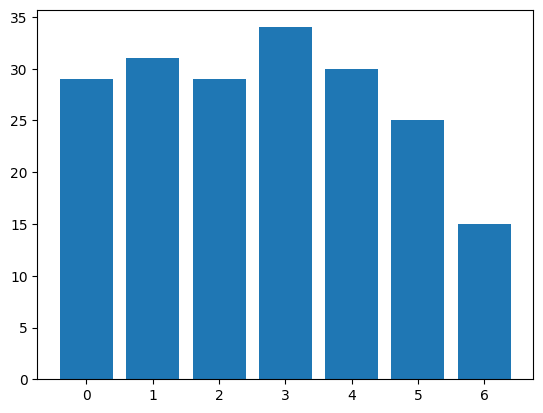

In [12]:
# Creating histogram
plt.bar(fraud_per_weekday['TransactionWeekDay'], fraud_per_weekday['FraudResult'])
 
# Show plot
plt.show()

We see that there is no pattern that appears between the week days. A fraud can happens any day of the week. Given that, I will not use `TransactionWeekDay` in my model, because it didn't give me any useful information.

# Fraud frequency per month

We will know plot the fraud frequency regarding the month.

In [13]:
# Create DataFram with the month and fraud
fraud_month = pd.DataFrame({
    'TransactionMonth': transaction_start_time_details['TransactionMonth'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
fraud_per_month = fraud_month.groupby('TransactionMonth').sum()
fraud_per_month.reset_index(inplace=True)

fraud_per_month.head(10)

,TransactionMonth,FraudResult
0,1,64
1,2,53
2,11,14
3,12,62


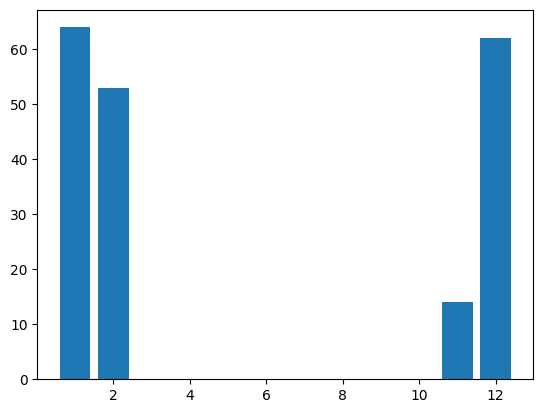

In [14]:
# Creating bar graph
plt.bar(fraud_per_month['TransactionMonth'], fraud_per_month['FraudResult'])
 
# Show plot
plt.show()

As we can see, there is a periodical pattern. The fraud generally happens during the month of november to february.

We can then use this data in our model.

We will make this variable categorical, but as we can see, only 4 of 12 months of the year is subject to fraud. Given that, it can be useless to have a category for each month regarding the 3/4 of them doesn't give use information.

Then, we will apply a **Target Encoding** so that we reduce the dimensionnality of our training set.

Each month will be replaced by its propability to have a fraud given the following formula:

$$ encoding = \frac{fraudMonthOccurences}{totalOccurences} $$

In [15]:
from category_encoders import MEstimateEncoder

transaction_month_encoder = pd.Series()

def encode_month(destination):
    encoder = MEstimateEncoder(cols=["TransactionMonth"], m=5.0)

    # # Fit the encoder on the encoding split.
    destination['TransactionMonthEncoded'] = encoder.fit_transform(destination['TransactionMonth'], destination['FraudResult'])

    # # Encode the Zipcode column to create the final training data   
    print(transaction_month_encoder)

    return destination

In [16]:
fraud_month = encode_month(fraud_month)
fraud_month.head()

Series([], dtype: object)


,TransactionMonth,FraudResult,TransactionMonthEncoded
TransactionId,,,
TransactionId_76871,11,0,0.001123
TransactionId_73770,11,0,0.001123
TransactionId_26203,11,0,0.001123
TransactionId_380,11,0,0.001123
TransactionId_28195,11,0,0.001123


# Fraud frequency per hour

We will analyse the frequency of the fraud regarding the hour of the day.

In [17]:
# Create DataFram with the month and fraud
fraud_hour = pd.DataFrame({
    'TransactionHour': transaction_start_time_details['TransactionHour'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
fraud_per_hour = fraud_hour.groupby('TransactionHour').sum()
fraud_per_hour.reset_index(inplace=True)

fraud_per_hour.head(10)

,TransactionHour,FraudResult
0,0,1
1,1,0
2,2,0
3,3,7
4,4,0
5,5,6
6,6,7
7,7,9
8,8,8
9,9,10


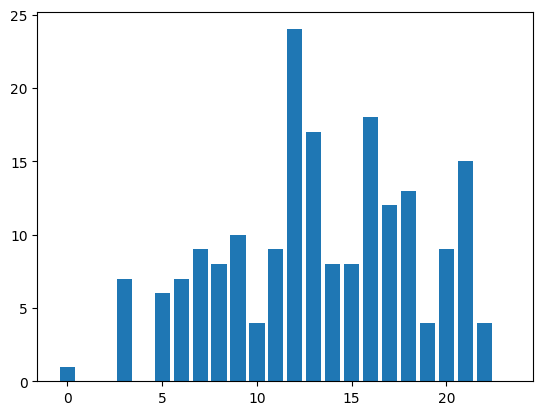

In [18]:
# Creating bar graph
plt.bar(fraud_per_hour['TransactionHour'], fraud_per_hour['FraudResult'])
 
# Show plot
plt.show()

In [19]:
from sklearn.cluster import KMeans

def kmeansFraudHour(destination, clusters=3, computeFraudPerHour=True):
    # Create KMeans instance
    kmeans = KMeans(n_clusters=clusters)

    # Check if we have to compute how many fraud happens per hour
    if computeFraudPerHour:
        fraud_hour = pd.DataFrame({
            'TransactionHour': destination['TransactionHour'],
            'FraudResult': destination['FraudResult'],
        })

        # Group the dataframe by month
        fraud_per_hour = fraud_hour.groupby('TransactionHour').sum()
        fraud_per_hour.reset_index(inplace=True)

        # Get the cluster result
        destination['TransactionHourCluster'] = kmeans.fit_predict(fraud_per_hour.loc[:, ['FraudResult']])
        destination['TransactionHourCluster'] = destination['TransactionHourCluster'].astype('category')

    else:
        # Get the cluster result
        destination['TransactionHourCluster'] = kmeans.fit_predict(destination.loc[:, ['FraudResult']])
        destination['TransactionHourCluster'] = destination['TransactionHourCluster'].astype('category')

    return destination

In [20]:
fraud_per_hour = kmeansFraudHour(fraud_per_hour, computeFraudPerHour=False)
fraud_per_hour.groupby('TransactionHourCluster').head()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,TransactionHour,FraudResult,TransactionHourCluster
0,0,1,1
1,1,0,1
2,2,0,1
3,3,7,0
4,4,0,1
5,5,6,0
6,6,7,0
7,7,9,0
8,8,8,0
10,10,4,1


<Axes: xlabel='TransactionHour', ylabel='FraudResult'>

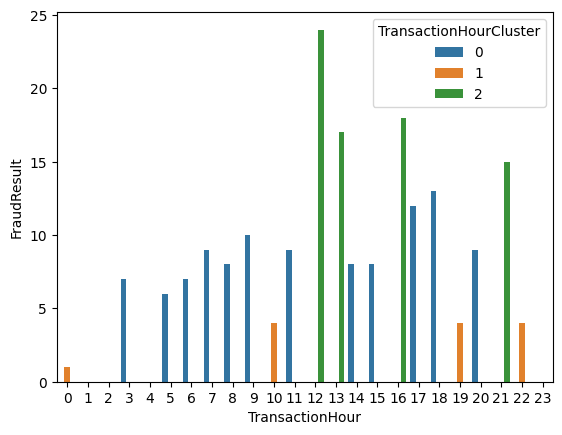

In [21]:
# Creating bar graph
sns.barplot(data=fraud_per_hour, x="TransactionHour", y="FraudResult", hue="TransactionHourCluster")

**TODO**

DOC

## Result

As we can see in this plot, it is not a periodical pattern and so the month and week day does not give us any additional information.

But for the sake of the analysis, we will keep `TransactionMonth` and `TransactionWeekDay`, because `TransactionStartTime` will be just converted in a categorical variable that will bias our model.

In [22]:
def get_transaction_start_date_data(destination):
    # Get useful data from TransactionStartDate
    destination = apply_transaction_start_date(destination)
    
    # Remove TransactionWeekDay
    destination.drop(colname='TransactionWeekDay', inplace=True)

    # Clusterise hour
    kmeansFraudHour(destination)

## Way to pay

For the next analysis, we will look at `Amount`. In the variable description, it says that the positive values refers to debit and negative to credit.

Given that information, we can analyse if a debit or credit payment affect the fraud violation.

The first step will be to extract this information, we will then create a column name `PaymentWay`. This column will have `0` if it is a debit and `1` if credit.

 * **PaymentWay**: 0 if debit, 1 if credit

In [23]:
def apply_payment_way(destination):
    # Get the payment information
    destination['PaymentWay'] = np.where(destination['Amount'] > 0, 'debit', 'credit')

    # Remove the Amount columns
    destination.drop(columns=['Amount'], inplace=True)

    return destination

In [24]:
# Create an empty DataFrame
payment_information = training_data.loc[:, ['Amount']].copy()

# Apply the payment way function
payment_information = apply_payment_way(payment_information)

payment_information.head()

,PaymentWay
TransactionId,
TransactionId_76871,debit
TransactionId_73770,credit
TransactionId_26203,debit
TransactionId_380,debit
TransactionId_28195,credit


As we can see, the payment way does not affect the fraud violation.

### Fraud frequency per Payment Way

We will analyse the fraud frequency regarding the payment method used: Debit or Credit.

In [25]:
# Create DataFram with the month and fraud
fraud_payment_way = pd.DataFrame({
    'PaymentWay': payment_information['PaymentWay'],
    'FraudResult': training_data['FraudResult'],
})


# Group the dataframe by month
fraud_per_payment_way = fraud_payment_way.groupby('PaymentWay').sum()
fraud_per_payment_way.reset_index(inplace=True)

fraud_per_payment_way.head(10)

,PaymentWay,FraudResult
0,credit,5
1,debit,188


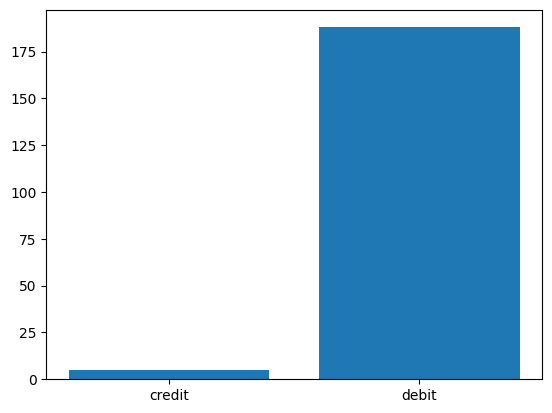

In [26]:
# Creating bar graph
plt.bar(fraud_per_payment_way['PaymentWay'], fraud_per_payment_way['FraudResult'])
 
# Show plot
plt.show()

As we can see on the chart above, there is a lot more fraud by debit than credit. We can then use this categorical variable during our training phase.

## Pricing strategy

We are going to analyse the pricing strategy and check its influence on the fraud detection.

In [27]:
# Retrieve the pricing strategy
pricing_strategy = training_data.loc[:, ['PricingStrategy', 'FraudResult']]

# Check the number of fraud per princing strategy
fraud_per_pricing_strategy = pricing_strategy.groupby('PricingStrategy').sum()
fraud_per_pricing_strategy.reset_index(inplace=True)

fraud_per_pricing_strategy.head()

,PricingStrategy,FraudResult
0,0,36
1,1,7
2,2,139
3,4,11


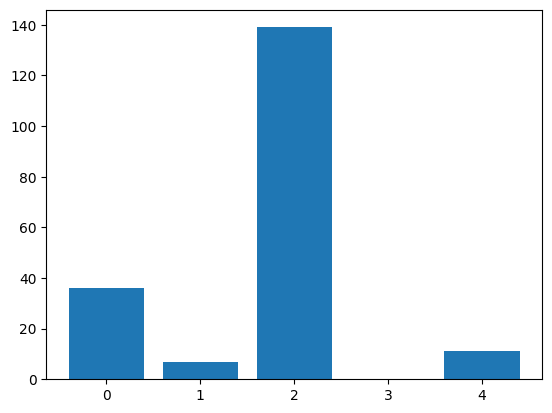

In [28]:
# Creating bar graph
plt.bar(fraud_per_pricing_strategy['PricingStrategy'], fraud_per_pricing_strategy['FraudResult'])
 
# Show plot
plt.show()

# Value

**TODO** Clustering on value

In [29]:
from sklearn.cluster import KMeans

def kmeansValue(destination, clusters=3, dropValue=True):
    destination['Value'] = (destination['Value'] - destination['Value'].min()) / (destination['Value'].max() - destination['Value'].min()) 

    # Create KMeans instance
    kmeans = KMeans(n_clusters=clusters)

    # Get the cluster result
    destination['ValueCluster'] = kmeans.fit_predict(destination.loc[:, ['Value']])
    destination['ValueCluster'] = destination['ValueCluster'].astype('category')

    if dropValue:
        destination.drop(columns=['Value'], inplace=True)

    return destination

In [30]:
# Get Value
Value = training_data.loc[:, ['Value']].copy()

# Apply KMeans onn Value
Value = kmeansValue(Value, clusters=5, dropValue=False)

Value.head()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Value,ValueCluster
TransactionId,,
TransactionId_76871,0.000101,0
TransactionId_73770,0.000002,0
TransactionId_26203,0.000050,0
TransactionId_380,0.002206,0
TransactionId_28195,0.000065,0


<Axes: xlabel='ValueCluster', ylabel='Value'>

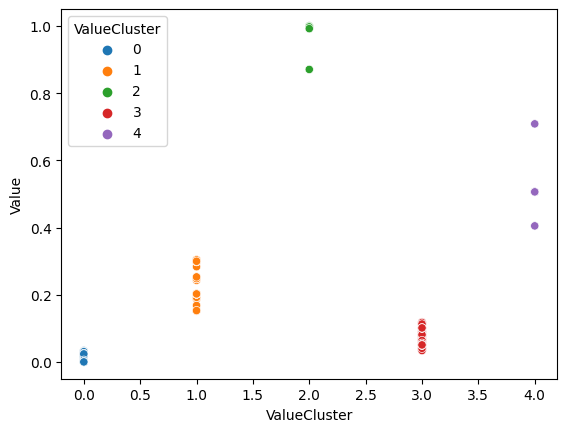

In [31]:
sns.scatterplot(data=Value, x='ValueCluster', y='Value', hue='ValueCluster')

In [32]:
ValuePaymentWay = training_data.loc[:, ['Amount', 'Value']].copy()

ValuePaymentWay = apply_payment_way(ValuePaymentWay)

kmeans = KMeans(n_clusters=2)

ValuePaymentWay['PaymentWay'], _ = pd.factorize(ValuePaymentWay['PaymentWay'])

# Get the cluster result
ValuePaymentWay['ValueCluster'] = kmeans.fit_predict(ValuePaymentWay.loc[:, ['Value', 'PaymentWay']])
ValuePaymentWay['ValueCluster'] = ValuePaymentWay['ValueCluster'].astype('category')


ValuePaymentWay['ValueCluster'].value_counts()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueCluster
0    95626
1       36
Name: count, dtype: int64

# Value per Customer

A fraud violation can be affected by a customer, but as I said before I don't want to categorise a fraud based on the customer. But we can extract the total amount of money that a customer has spent in our training phase.

In [33]:
def get_value_per_customer(destination):
    # Get sum of each value for every customer
    customer_id_value = destination.groupby(['CustomerId'])[['Value']].sum().reset_index()

    # Add the customer total value in the destination
    for row in customer_id_value.to_dict('records'):
        destination.loc[destination['CustomerId'] == row['CustomerId'], 'ValuePerCustomer'] = row['Value']    

    return destination

In [34]:
training_data_copy = get_value_per_customer(training_data.copy())

training_data_copy.head(10)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ValuePerCustomer
TransactionId,,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,203847.0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,203847.0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,1000.0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,286623.0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,286623.0
TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,2000.0,2000,2018-11-15T03:35:10Z,2,0,2000.0
TransactionId_118063,BatchId_118460,AccountId_2442,SubscriptionId_1980,CustomerId_2858,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,10000.0,10000,2018-11-15T03:44:31Z,4,0,129800.0
TransactionId_100640,BatchId_38561,AccountId_4841,SubscriptionId_3829,CustomerId_2858,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-500.0,500,2018-11-15T03:45:13Z,2,0,129800.0
TransactionId_51905,BatchId_93774,AccountId_272,SubscriptionId_4731,CustomerId_598,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,500.0,500,2018-11-15T04:14:59Z,2,0,8340.0


## Channel ID

In [35]:
# Retrieve the pricing strategy
channel_id = training_data.loc[:, ['ChannelId', 'FraudResult']]

# Check the number of fraud per princing strategy
fraud_per_channel_id = channel_id.groupby('ChannelId').sum()
fraud_per_channel_id.reset_index(inplace=True)

fraud_per_channel_id.head()

,ChannelId,FraudResult
0,ChannelId_1,4
1,ChannelId_2,5
2,ChannelId_3,184
3,ChannelId_5,0


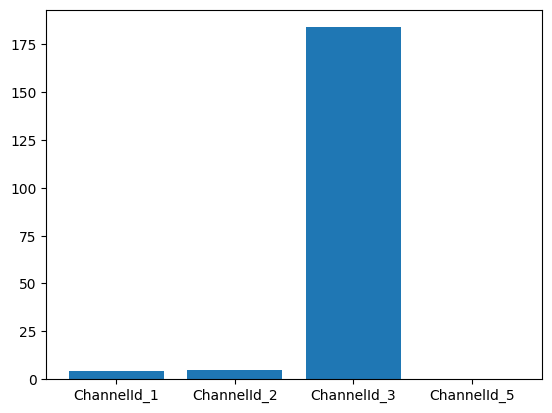

In [36]:
# Creating bar graph
plt.bar(fraud_per_channel_id['ChannelId'], fraud_per_channel_id['FraudResult'])
 
# Show plot
plt.show()

## Conclusion

At the end of our journey, we have a dataset with the following columns=

 * `Value`

## Categorise the data

Now we are going the categorise our discrete value. We will apply a One-Hot Encoder on `ProductCategory` and `ChannelId`.

As a reminder, a One-Hot Encoder will create new binary columns, indicating the presence of each possible values from the original data.

![One-Hot Encoding](./pictures/one-hot-encoding.png)

One-Hot Encoding works well when the categorical variable takes on a small number of values (15 regarding [Kaggle](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding)).

We will then check the number of unique categories in every one of our columns, and apply One-Hot Encoding if the distinct values is less than `15`.


## Conclusion

At the end of our journey, we have a dataset with the following columns=

 * `TransactionId`
 * `Value`
 * 


As we can see, `ProductCategory` has 9 distincts values and `ChannelId`has 4. We can then apply One-Hot Encoding on each column.

# Unbalanced dataset

Before explaining what is a unbalanced datasets, I will show you the proportion between the non-fraud and fraud rows of the dataset.

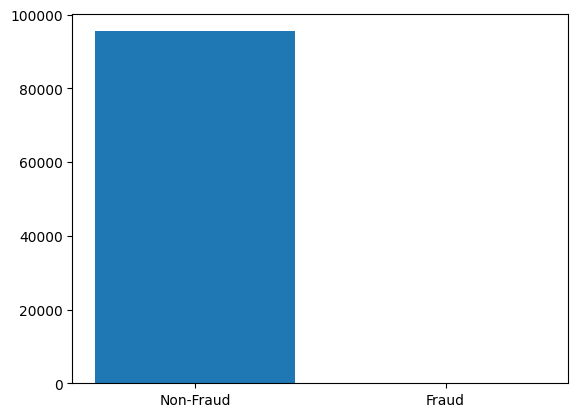

Fraud percentage: 0.20175200183981098


In [65]:
# Get FraudResult
fraud_result = training_data[['FraudResult']].copy()

# Count the occurence of every value
fraud_counts = fraud_result.value_counts()

# Creating bar graph
plt.bar(['Non-Fraud', 'Fraud'], fraud_counts)
 
# Show plot
plt.show()

# Compute the percentage value of fraud
fraud_percentage = (y.sum() / len(y)) * 100.0

print(f'Fraud percentage: {fraud_percentage}')

As we can see, only 0.2% of our data is a fraud. We are in frount of an **unbalanced dataset**.

The solution is to oversample. The purpose is to create some new false rows in our dataset to make it more balanced. The new row will be generated regarding the other ones.

We will use the function `SMOTE` that will generate our new rows.

For the sake of the illustration, I will remove the string columns from the dataset.

In [66]:
cols_to_use = ['Amount', 'Value', 'PricingStrategy']

# Extract information from dataset
X_unbalanced = training_data[cols_to_use].copy()
y_unbalanced = training_data['FraudResult'].copy()

In [67]:
from imblearn.over_sampling import SMOTE

# Declare our oversampler
oversampler = SMOTE(random_state=0, sampling_strategy=0.5)

# Fit and oversample our data
X_oversampled, y_oversampled = oversampler.fit_resample(X_unbalanced, y_unbalanced)

# Rebuild the dataset
oversampled_dataset = pd.concat([X_oversampled, y_oversampled], axis=1)
oversampled_dataset.head()

,Amount,Value,PricingStrategy,FraudResult
0,1000.0,1000,2,0
1,-20.0,20,2,0
2,500.0,500,2,0
3,20000.0,21800,2,0
4,-644.0,644,2,0


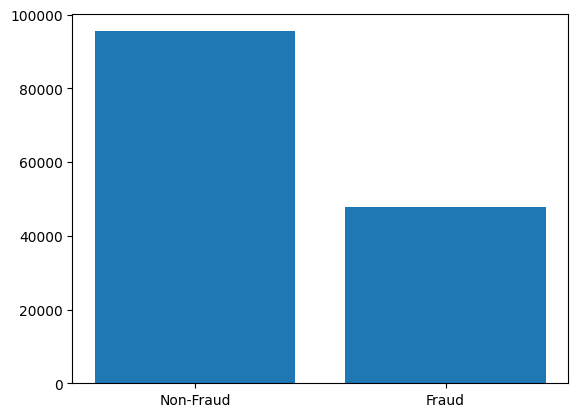

Fraud percentage: 33.33310056353568


In [68]:
# Get FraudResult
fraud_result = oversampled_dataset[['FraudResult']].copy()

# Count the occurence of every value
fraud_counts = fraud_result.value_counts()

# Creating bar graph
plt.bar(['Non-Fraud', 'Fraud'], fraud_counts)
 
# Show plot
plt.show()

# Compute the percentage value of fraud
fraud_percentage = (oversampled_dataset['FraudResult'].sum() / len(oversampled_dataset)) * 100.0

print(f'Fraud percentage: {fraud_percentage}')

Now our dataset is balanced and we can start the training of our model.

# Set our data for the model

Here we are going to set the data that we will use to create our model.

In [47]:
# COLS_TO_USE = ['ProductCategory', 'ChannelId', 'Amount', 'TransactionStartTime', 'PricingStrategy']
COLS_TO_USE = ['Amount', 'TransactionStartTime', 'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy', 'CustomerId', 'ProviderId']

def prepare_dataset(data_source):
    dataset = data_source[COLS_TO_USE].copy()

    # Apply data transformation
    dataset = get_value_per_customer(dataset)
    # dataset = get_value_per_provider(dataset)
    dataset = apply_payment_way(dataset)
    dataset = apply_transaction_start_date(dataset)

    dataset.drop(columns=['CustomerId', 'ProviderId', 'TransactionWeekDay'], inplace=True)
    # dataset = kmeansValue(dataset, clusters=5)

    return dataset

In [48]:
from sklearn.model_selection import train_test_split

# Category where apply a One-Hot encoding
categorical_cols = ['ProductCategory', 'ChannelId', 'PaymentWay', 'PricingStrategy']

# Check my dataset
X = prepare_dataset(training_data)
y = training_data['FraudResult']

# Apply One-Hot encoding
X = pd.get_dummies(data=X, columns=categorical_cols)

# Stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)

In [49]:
X_train.head()

,Value,ValuePerCustomer,TransactionMonth,TransactionHour,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,...,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,PaymentWay_credit,PaymentWay_debit,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
TransactionId,,,,,,,,,,,,,,,,,,,,,
TransactionId_10839,50,105820.0,1,18,False,False,True,False,False,False,...,False,True,False,False,True,False,False,False,True,False
TransactionId_115893,20000,40000.0,12,19,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
TransactionId_28380,392,171434.0,2,10,False,False,True,False,False,False,...,False,True,False,False,True,False,False,False,True,False
TransactionId_114004,500,1510.0,1,12,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,True
TransactionId_3471,50,1171282.0,2,16,False,False,True,False,False,False,...,False,True,False,False,True,False,False,False,True,False


In [50]:
y_train.head()

TransactionId
TransactionId_10839     0
TransactionId_115893    0
TransactionId_28380     0
TransactionId_114004    0
TransactionId_3471      0
Name: FraudResult, dtype: int64

**TODO**

A this time we have
 * Column 1
 * COlumn 2
 * ...

In [51]:
# Explain over sampling

# Create the model

We will know define our model. In my case, I choose a **RandomForest** because it work well with a high number of categorical data.

I will play over 2 hyperparameters:

 * n_estimators: Number of trees in the forest
 * max_depth: Maximum depth of a tree

To optimise these parameters, I use `GridSearchCV`.

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(n_estimators=5, max_depth=20, random_state=0)
parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [20, 30, 40],
}

grid_search = GridSearchCV(model, param_grid = parameters , scoring = 'f1', cv = 3, n_jobs = 2,)
grid_scores = grid_search.fit(X_train , y_train)

In [57]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)
0.8629629629629628
{'max_depth': 20, 'n_estimators': 150}


In [59]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier


pipeline = Pipeline([
    ('smote', SMOTE(random_state=0, sampling_strategy=0.3)),
    ('model', RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], random_state = 0)),
])


In [ ]:
model = GradientBoostingClassifier(n_estimators=5, max_depth=20, learning_rate=0.1, random_state=1)
parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [20, 30, 40],
    "learning_rate": [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(model, param_grid = parameters , scoring = 'f1', cv = 3, n_jobs = 2,)
grid_scores = grid_search.fit(X_train , y_train)

NameError: name 'GradientBoostingClassifier' is not defined

In [ ]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

GradientBoostingClassifier(learning_rate=0.01, max_depth=20, n_estimators=50,
                           random_state=1)
0.8764814440627736
{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 50}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0, sampling_strategy=0.4)),
    # ('scale', StandardScaler(with_mean=False)),
    ('model', GradientBoostingClassifier(n_estimators=50, max_depth=20, learning_rate=0.01, random_state=0)),
])


We train our model with the training dataset.

In [60]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy=0.3)),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=150,
                                        random_state=0))])

We check the model prediction score. We take `F1 score` because it reflect a score for binary classification.

In [61]:
preds = pipeline.predict(X_test)

print(f1_score(y_test, preds))

0.7951807228915662


# Test dataset

Now that we have our model, we can predict the `FraudResult` of the test dataset ad submit it to [Xente](https://zindi.africa/competitions/xente-fraud-detection-challenge/submissions).

We first load the data from './data/test.csv' and prepare the dataset.

In [62]:
# Path to the test data
test_data_path = './data/test.csv'

# Load test data
test_data = pd.read_csv(test_data_path)

# Set TransactionId as index
test_data.set_index('TransactionId', inplace=True)

# Get the target
X_valid = prepare_dataset(test_data.copy())

# Apply One-Hot encoding
X_valid = pd.get_dummies(data=X_valid, columns=categorical_cols)

# Remove the columns that are not in the training dataset
X_valid.drop(columns=[col for col in X_valid.columns if col not in X_train.columns], inplace=True)

# Add the columns that are missing from the training set
for col in X_train.columns:
    if col not in X_valid.columns:
      X_valid.insert(X_valid.shape[1], col, pd.Series([0] * X_valid.shape[0]))
      X_valid[col].fillna(0, inplace=True)

# Set the same column order that in our training set
X_valid = X_valid[X_train.columns]

X_valid.head()

,Value,ValuePerCustomer,TransactionMonth,TransactionHour,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,...,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,PaymentWay_credit,PaymentWay_debit,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
TransactionId,,,,,,,,,,,,,,,,,,,,,
TransactionId_50600,1000,10500.0,2,10,True,False,False,False,0.0,False,...,False,False,True,False,False,True,False,False,False,True
TransactionId_95109,2000,1072725.0,2,10,False,False,True,False,0.0,False,...,False,False,True,False,False,True,False,False,True,False
TransactionId_47357,50,10500.0,2,10,False,False,True,False,0.0,False,...,False,True,False,False,True,False,False,False,True,False
TransactionId_28185,3000,53240.0,2,10,True,False,False,False,0.0,False,...,False,False,True,False,False,True,False,False,False,True
TransactionId_22140,60,53240.0,2,10,False,False,True,False,0.0,False,...,False,True,False,False,True,False,False,False,True,False


We make the prediction of the test dataset.

In [63]:

pred = pd.Series(pipeline.predict(X_valid))

pred.head()


0    0
1    0
2    0
3    0
4    0
dtype: int64

We load our result into the submission file './data/my_submission.csv'.

In [64]:
# Path of the submission template file
sample_submission_path = './data/sample_submission.csv'

# Read data from file
sample_submission =  pd.read_csv(sample_submission_path)

# Add our result to the submission file
sample_submission['FraudResult'] = pred

# Write the result into our submission file
sample_submission.to_csv('./data/my_submission.csv', index=False)